### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [527]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [529]:
class MyDecisionTreeClassifier(BaseEstimator):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, min_Q_split=0.0001, feature_linspace=20, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.min_Q_split = min_Q_split
        self.feature_linspace = feature_linspace
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances = dict()
        
        # Сразу определяем нужный критерий информативности
        if criterion == 'error':
            self.F = error
        elif criterion == 'entropy':
            self.F = entropy
        else:
            self.F = gini
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __div_samples_only_y(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        max_Q = -np.inf
        best_feature = None
        best_threshold = None
        for feature_id in range(x.shape[1]):
            min_val = x[:, feature_id].min()
            max_val = x[:, feature_id].max()
            thresholds = np.linspace(start=min_val, stop=max_val, num=self.feature_linspace)[:-1]
            for threshold in thresholds:
                cur_Q = self.Q(x, y, feature_id, threshold)
                if cur_Q > max_Q:
                    max_Q = cur_Q
                    best_feature = feature_id
                    best_threshold = threshold
        if best_feature not in self.feature_importances:
            self.feature_importances[best_feature] = max_Q
        else:
            self.feature_importances[best_feature] += max_Q
        return best_feature, best_threshold, max_Q

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Проверяем различные критерии останова
        if depth <= self.max_depth and x.shape[0] >= self.min_samples_split and np.unique(y).shape[0] != 1:
            split_info = self.__find_threshold(x, y)
            # При малом максимальном Q делаем вершину листовой
            if split_info[2] < self.min_Q_split:
                class_distr = np.bincount(y)
                most_prob_class = class_distr.argmax()
                class_prob = class_distr[most_prob_class] / y.shape[0]
                self.tree[node_id] = (self.LEAF_TYPE, most_prob_class, class_prob)
                return
            self.tree[node_id] = (self.NON_LEAF_TYPE, split_info[0], split_info[1])
            div = self.__div_samples(x, y, split_info[0], split_info[1])
            self.__fit_node(div[0], div[2], 2 * node_id + 1, depth + 1)
            self.__fit_node(div[1], div[3], 2 * node_id + 2, depth + 1)
        else:
            class_distr = np.bincount(y)
            most_prob_class = class_distr.argmax()
            class_prob = class_distr[most_prob_class] / y.shape[0]
            self.tree[node_id] = (self.LEAF_TYPE, most_prob_class, class_prob)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        values = np.array(list(self.feature_importances.values()))
        features = np.array(list(self.feature_importances.keys()))
        arg = np.argsort(values)
        features = features[arg][::-1]
        values = values[arg][::-1]
        return features, values
    
    # Функция считающая критерий информативности
    def Q(self, x, y, feature_id, threshold):
        div = self.__div_samples_only_y(x, y, feature_id, threshold)
        if div[0].shape[0] == 0 or div[1].shape[0] == 0:
            return -np.inf
        return self.F(y) - div[0].shape[0] / y.shape[0] * self.F(div[0]) - div[1].shape[0] / y.shape[0] * self.F(div[1])

# Функции реализующие соответствующие критерии информативности
def error(y):
    return 1 - np.bincount(y).max() / y.shape[0]

def gini(y):
    probabilities = np.bincount(y) / y.shape[0]
    return 1  - (probabilities**2).sum()

def entropy(y):
    probabilities = np.bincount(y) / y.shape[0]
    probabilities[probabilities == 0] = 0.000001
    return -(probabilities * np.log(probabilities)).sum()

In [610]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, min_Q_split=0.16, feature_linspace=4)
clf = DecisionTreeClassifier(min_samples_split=2)

In [611]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [612]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
len(my_clf.tree)

5

In [589]:
print("SKLEARN SCORE:", accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print("MY SCORE:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

SKLEARN SCORE: 0.7777777777777778
MY SCORE: 0.8333333333333334


Проведу множество испытаний, чтобы убедиться в том, что моя реализация не уступает DecisionTreeClassifier из sklearn.

In [469]:
N = 100

sklearn_scores = np.zeros(N)
my_scores = np.zeros(N)

for i in range(N):
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, min_Q_split=0.16, feature_linspace=4)
    clf = DecisionTreeClassifier(min_samples_split=2)
    X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
    my_clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    sklearn_scores[i] = accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)
    my_scores[i] = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

print("SKLEARN MEAN SCORE:", sklearn_scores.mean())
print("MY MEAN SCORE:", my_scores.mean())   

SKLEARN MEAN SCORE: 0.8983333333333333
MY MEAN SCORE: 0.901111111111111


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

Скорость работы fit'а напрямую зависит от числа вершин в дереве, и в зависимости от числа вершин моя реализация работает в 10-15 раз медленнее sklearn реализации. 

In [614]:
%timeit clf.fit(X_train, y_train)

642 µs ± 3.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [613]:
%timeit my_clf.fit(X_train, y_train)

7.75 ms ± 56.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [615]:
len(my_clf.tree)

5

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [627]:
df = pd.read_csv("Speed Dating Data.csv", encoding='latin1')

Буду добавлять признаки, которые считаю значимыми.

In [630]:
my_df = pd.DataFrame()

my_df['iid'] = df.iid.fillna(0)

my_df['pid'] = df.pid.fillna(0)

my_df['gender'] = df.gender

my_df['int_corr'] = df.int_corr.fillna(0)

my_df['samerace'] = df.samerace

my_df['age'] = df.age.fillna(df.age.mean())

my_df['diff_age'] = my_df.age - df.age_o.fillna(df.age.mean())

my_df['imprace'] = df.imprace.fillna(df.imprace.mean())

my_df['imprelig'] = df.imprelig.fillna(df.imprelig.mean())

my_df['date'] = df.date.fillna(df.date.mean())

my_df['go_out'] = df.go_out.fillna(df.go_out.mean())

my_df['exphappy'] = df.exphappy.fillna(df.exphappy.mean())

my_df['dec'] = df.dec

my_df['attr'] = df.attr.fillna(df.attr.mean())
my_df['sinc'] = df.sinc.fillna(df.sinc.mean())
my_df['intel'] = df.intel.fillna(df.intel.mean())
my_df['fun'] = df.fun.fillna(df.fun.mean())
my_df['amb'] = df.amb.fillna(df.amb.mean())
my_df['shar'] = df.shar.fillna(df.shar.mean())
my_df['like'] = df.like.fillna(df.like.mean())

my_df['prob'] = df.prob.fillna(df.prob.mean())

my_df['met'] = df.met.fillna(0)

my_df['match_es'] = df.match_es.fillna(0)

my_df['satis_2'] = df.satis_2.fillna(df.satis_2.mean())

my_df['you_call'] = df.you_call.fillna(df.you_call.mean())

my_df['them_cal'] = df.them_cal.fillna(df.them_cal.mean())

my_df['target'] = df.match

In [631]:
my_df

,iid,pid,gender,int_corr,samerace,age,diff_age,imprace,imprelig,date,...,amb,shar,like,prob,met,match_es,satis_2,you_call,them_cal,target
0,1,11.0,0,0.14,0,21.0,-6.0,2.0,4.0,7.0,...,6.000000,5.000000,7.0,6.000000,2.0,4.0,6.0,1.0,1.0,0
1,1,12.0,0,0.54,0,21.0,-1.0,2.0,4.0,7.0,...,5.000000,6.000000,7.0,5.000000,1.0,4.0,6.0,1.0,1.0,0
2,1,13.0,0,0.16,1,21.0,-1.0,2.0,4.0,7.0,...,5.000000,7.000000,7.0,5.207523,1.0,4.0,6.0,1.0,1.0,1
3,1,14.0,0,0.61,0,21.0,-2.0,2.0,4.0,7.0,...,6.000000,8.000000,7.0,6.000000,2.0,4.0,6.0,1.0,1.0,1
4,1,15.0,0,0.21,0,21.0,-3.0,2.0,4.0,7.0,...,6.000000,6.000000,6.0,6.000000,2.0,4.0,6.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,526.0,1,0.64,0,25.0,-1.0,1.0,1.0,2.0,...,6.777524,5.474559,2.0,5.000000,0.0,3.0,5.0,2.0,0.0,0
8374,552,527.0,1,0.71,0,25.0,1.0,1.0,1.0,2.0,...,4.000000,5.474559,4.0,4.000000,0.0,3.0,5.0,2.0,0.0,0
8375,552,528.0,1,-0.46,0,25.0,-4.0,1.0,1.0,2.0,...,8.000000,5.474559,6.0,5.000000,0.0,3.0,5.0,2.0,0.0,0
8376,552,529.0,1,0.62,0,25.0,3.0,1.0,1.0,2.0,...,6.777524,5.000000,5.0,5.000000,0.0,3.0,5.0,2.0,0.0,0


Создадим отдельно таблицу с мужчинами и женщинами, и сджойним их.

In [632]:
df_male = my_df.query('gender == 1').drop(['gender'], axis=1)
df_female = my_df.query('gender == 0').drop(['gender', 'target', 'int_corr', 'samerace', 'diff_age'], axis=1)
df_female.columns = df_female.columns + '_f'
df_male = df_male.rename(columns={'pid': 'iid_f'})
df_female = df_female.rename(columns={'pid_f': 'iid'})
df_male = df_male.rename(columns={'target_m': 'target'})

In [633]:
my_df = pd.merge(df_male, df_female, on=['iid', 'iid_f'])
my_df

,iid,iid_f,int_corr,samerace,age,diff_age,imprace,imprelig,date,go_out,...,fun_f,amb_f,shar_f,like_f,prob_f,met_f,match_es_f,satis_2_f,you_call_f,them_cal_f
0,11,1.0,0.14,0,27.0,6.0,7.0,3.0,5.0,4.0,...,7.0,6.0,5.0,7.0,6.0,2.0,4.0,6.00000,1.000000,1.000000
1,11,2.0,0.29,1,27.0,3.0,7.0,3.0,5.0,4.0,...,4.0,6.0,3.0,6.0,4.0,2.0,3.0,5.00000,0.000000,0.000000
2,11,3.0,-0.24,1,27.0,2.0,7.0,3.0,5.0,4.0,...,7.0,8.0,9.0,8.0,7.0,1.0,0.0,5.71151,0.780825,0.981631
3,11,4.0,-0.18,1,27.0,4.0,7.0,3.0,5.0,4.0,...,5.0,8.0,7.0,6.0,7.0,2.0,2.0,4.00000,0.000000,0.000000
4,11,5.0,-0.43,1,27.0,6.0,7.0,3.0,5.0,4.0,...,2.0,2.0,2.0,7.0,5.0,2.0,0.0,7.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,552,526.0,0.64,0,25.0,-1.0,1.0,1.0,2.0,1.0,...,2.0,6.0,5.0,6.0,1.0,0.0,2.0,3.00000,0.000000,1.000000
4180,552,527.0,0.71,0,25.0,1.0,1.0,1.0,2.0,1.0,...,3.0,7.0,2.0,2.0,2.0,0.0,0.0,5.00000,0.780825,0.981631
4181,552,528.0,-0.46,0,25.0,-4.0,1.0,1.0,2.0,1.0,...,2.0,2.0,1.0,2.0,1.0,0.0,2.0,4.00000,0.000000,0.000000
4182,552,529.0,0.62,0,25.0,3.0,1.0,1.0,2.0,1.0,...,5.0,3.0,6.0,6.0,4.0,0.0,4.0,5.00000,0.000000,0.000000


In [634]:
target = np.array(my_df.target)
data_df = my_df.drop(['target'], axis=1)
data = np.array(data_df)

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [635]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, stratify=target)

In [636]:
my_clf = MyDecisionTreeClassifier(max_depth=6, min_samples_split=2, min_Q_split=0.00001, feature_linspace=50, criterion='entropy')
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
print(y_pred)
roc_auc_score(y_pred, y_test)

[1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 0]


1.0

In [637]:
my_clf.tree

{0: (0, 31, 0.0),
 1: (0, 11, 0.0),
 3: (1, 1, 1.0),
 4: (1, 0, 1.0),
 2: (1, 0, 1.0)}

In [638]:
features_id, values = my_clf.get_feature_importance()
col_names = data_df.columns
best_features = list(map(lambda x: col_names[x], features_id))
best_features

['dec', 'dec_f']

Как и следовало ожидать, пользуясь столбцами dec и dec_f которые отвечают за решение (yes/no) каждого из партнеров, можно выбить скор равный 1, так как целевая переменная match является логическим И переменных отвечающих за решение каждого партнера.

Наверняка такое решение не предполагалось, поэтому исключу столбцы dec и dec_f как слишком нечестные и повторю эксперимент.
Очевидно если использовать их, то они будут самыми важными и score модели будет гораздо выше. Если оставить хоть один из них, то другие параметры, которые характеризуют отношение человека к партнеру будут не важны, так как мы уже знаем его решение.

In [639]:
target = np.array(my_df.target)
data_df = my_df.drop(['target', 'dec', 'dec_f'], axis=1)
data = np.array(data_df)

Подберу критерий информативности и высоту дерева на кросс-валидации с использованием метрики ROC-AUC. 

In [640]:
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [518]:
criterion = ['error', 'gini', 'entropy'] 
arr = []

for c in criterion:
    my_clf = MyDecisionTreeClassifier(max_depth=5, min_samples_split=2,\
                                          min_Q_split=0.00001, feature_linspace=50, criterion=c)
    my_clf.fit(X_train, y_train)
    score = cross_val_score(my_clf, data, target, cv=5, scoring=make_scorer(roc_auc_score)).mean()
    print("CRITERION:", c, ", SCORE:", score)
    arr.append(score)

CRITERION: error , SCORE: 0.6510448926655051
CRITERION: gini , SCORE: 0.6510448926655051
CRITERION: entropy , SCORE: 0.6510448926655051


Как мы видим, все критерии информативности дают одинаковый результат, так что особой роли этот выбор не играет.
Я возьму энтропийный критерий в качестве критерия информативности.

Далее подберем оптимальную максимальную высоту дерева, так же на кросс-валидации.

In [502]:
depth = [1, 2, 3, 4, 5, 6, 7, 8]
arr = []

for d in depth:
    my_clf = MyDecisionTreeClassifier(max_depth=d, min_samples_split=2,\
                                          min_Q_split=0.00001, feature_linspace=50, criterion='entropy')
    my_clf.fit(X_train, y_train)
    score = cross_val_score(my_clf, data, target, cv=3, scoring=make_scorer(roc_auc_score)).mean()
    print("DEPTH:", d, ", SCORE:", score)
    arr.append(score)

DEPTH: 1 , SCORE: 0.5532602454277838
DEPTH: 2 , SCORE: 0.5937788113210342
DEPTH: 3 , SCORE: 0.6401252290466715
DEPTH: 4 , SCORE: 0.6439850151004898
DEPTH: 5 , SCORE: 0.6622004423447623
DEPTH: 6 , SCORE: 0.6446308878707835
DEPTH: 7 , SCORE: 0.6372366794155045
DEPTH: 8 , SCORE: 0.637343805905609


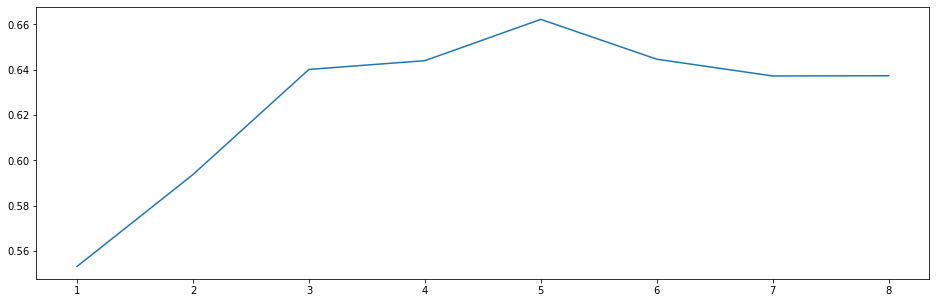

In [503]:
plt.figure(figsize=(16,5))
plt.plot(depth, arr)

Как видно из графика оптимальная максимальная высота дерева 5. Её и возьму для финальной модели.

In [621]:
n_samples = [1, 2, 5, 10, 25, 50, 75, 100]
arr = []

for n in n_samples:
    my_clf = MyDecisionTreeClassifier(max_depth=5, min_samples_split=n,\
                                          min_Q_split=0.00001, feature_linspace=50, criterion='entropy')
    my_clf.fit(X_train, y_train)
    score = cross_val_score(my_clf, data, target, cv=3, scoring=make_scorer(roc_auc_score)).mean()
    print("N_SAMPLES:", n, ", SCORE:", score)
    arr.append(score)

N_SAMPLES: 1 , SCORE: 0.6622004423447623
N_SAMPLES: 2 , SCORE: 0.6622004423447623
N_SAMPLES: 5 , SCORE: 0.6612904829593719
N_SAMPLES: 10 , SCORE: 0.659476041524321
N_SAMPLES: 25 , SCORE: 0.6545354719532245
N_SAMPLES: 50 , SCORE: 0.652701495951353
N_SAMPLES: 75 , SCORE: 0.6426122093878486
N_SAMPLES: 100 , SCORE: 0.6419040158249496


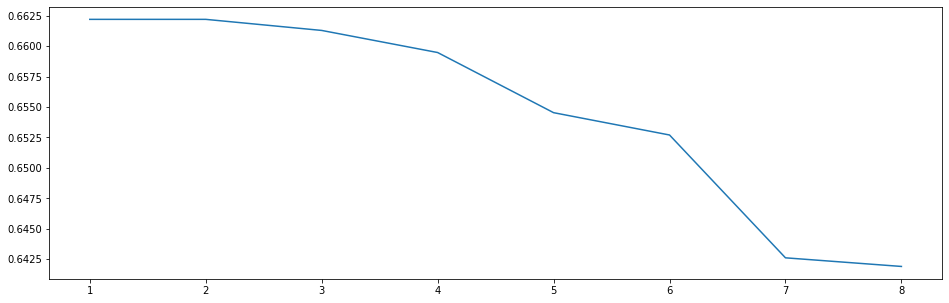

In [623]:
plt.figure(figsize=(16,5))
plt.plot(depth, arr)

Исходя из результатов кросс-валидации оставлю минимальное число объектов для сплита равным 2

Сравню результаты моей модели с sklearn реализацией и всеми нулями.

In [642]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, stratify=target)
my_clf = MyDecisionTreeClassifier(max_depth=5, min_samples_split=2,\
                                          min_Q_split=0.00001, feature_linspace=50, criterion='entropy')
clf = DecisionTreeClassifier(min_samples_split=2)
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

print("ALL ZEROS ACCURACY:", accuracy_score(y_pred=np.zeros(y_test.size), y_true=y_test))
print("SKLEARN ACCURACY SCORE:", accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print("MY ACCURACY SCORE:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

print("\nSKLEARN ROC-AUC SCORE:", roc_auc_score(clf.predict(X_test), y_test))
print("MY ROC-AUC SCORE:", roc_auc_score(my_clf.predict(X_test), y_test))

ALL ZEROS ACCURACY: 0.8353221957040573
SKLEARN ACCURACY SCORE: 0.8233890214797136
MY ACCURACY SCORE: 0.8591885441527446

SKLEARN ROC-AUC SCORE: 0.6806702282661486
MY ROC-AUC SCORE: 0.7567343555739743


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

Для того чтобы определить самые важные признаки, проведу множество испытаний и посмотрю какие признаки были в среднем самыми значимыми за все испытания.

In [568]:
N = 50

importance = np.zeros(data.shape[1])
roc_auc_score_ = np.zeros(N)
accuracy_score_ = np.zeros(N)

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, stratify=target)
    my_clf = MyDecisionTreeClassifier(max_depth=5, min_samples_split=10,\
                                          min_Q_split=0.00001, feature_linspace=50, criterion='entropy')
    my_clf.fit(X_train, y_train)
    roc_auc_score_[i] = roc_auc_score(my_clf.predict(X_test), y_test)
    accuracy_score_[i] = accuracy_score(my_clf.predict(X_test), y_test)
    features_id, values = my_clf.get_feature_importance()
    for i in range(features_id.shape[0]):
        importance[features_id[i]] += values[i]
        
print("MEAN ACCURACY SCORE:", accuracy_score_.mean())
print("MEAN ROC-AUC SCORE:", roc_auc_score_.mean())

MEAN ACCURACY SCORE: 0.8512171837708832
MEAN ROC-AUC SCORE: 0.7331642727801722


In [643]:
features = np.argsort(importance)[::-1]
col_names = data_df.columns
f = []
for idx in features:
    f.append(col_names[idx])

f

['attr_f',
 'them_cal_f',
 'fun_f',
 'prob',
 'like',
 'like_f',
 'age_f',
 'int_corr',
 'attr',
 'match_es',
 'age',
 'iid',
 'shar',
 'imprace',
 'fun',
 'match_es_f',
 'shar_f',
 'intel',
 'diff_age',
 'prob_f',
 'amb',
 'intel_f',
 'imprelig',
 'sinc',
 'satis_2',
 'exphappy_f',
 'you_call',
 'amb_f',
 'imprace_f',
 'date_f',
 'sinc_f',
 'go_out_f',
 'satis_2_f',
 'date',
 'go_out',
 'you_call_f',
 'them_cal',
 'exphappy',
 'iid_f',
 'imprelig_f',
 'met',
 'met_f',
 'samerace']

Можно заметить, что "парные" признаки, такие как like like_f, attr attr_f, имеют зачастую близкую важность, что логично, так как они показывают одни и те же характеристики, просто со стороны разных партнеров (парня и девушки соответственно). Выбирая 10 самых важных признаков такие пары буду объединять в один признак, чтобы получить более полную картину. 

В итоге 10 самых важных признаков по мнению моего алгоритма: 

'attr' - оценка внешности

'them_cal' - сколько человек из попаданий (match) предложили провести свидание 

'fun' - оценка "весёлости" 

'prob' - оценка человеком вероятности того, что решение партнера было положительным

'like' - насколько партнеры понравились друг другу.

'age' - возраст 

'int_corr' - корреляция интересов

'match_es' - сколько попаданий (match) произошло по мнению человека

'iid' - идентификатор человека

'shar' - оценка общих интересов


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

Осталась не до конца понятна обработка категориальных признаков. 

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

